# Auto ml for financial and textual data

## Auto ml for financial data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

random_state = 42

In [2]:
def flatten_financial_dataset(financial_dataset):
    object_length_in_rows = 5
    metadata_columns_length = 5
    
    per_object_columns = list(financial_dataset.columns[:metadata_columns_length].values)
    
    value_columns = financial_dataset.columns[metadata_columns_length:]
    new_columns = per_object_columns + [f'{col}_{i+1}' for i in range(object_length_in_rows) for col in value_columns]
    
    dfs = []
    
    for i in range(0, len(financial_dataset), object_length_in_rows):
        group = financial_dataset.iloc[i:i + object_length_in_rows]
        if len(group) < object_length_in_rows:
            break

        cik = group['cik'].iloc[0]
        ticker = group['ticker'].iloc[0]
        label = group['label'].iloc[0]
        subset = group['subset'].iloc[0]
        fiscal_periods = ';'.join(group['Fiscal Period'].astype(str).values)

        values = group.drop(columns=per_object_columns).values.flatten()
        
        dfs.append([cik, ticker, label, subset, fiscal_periods] + values.tolist())
    
    final_flatten_df = pd.DataFrame(dfs, columns=new_columns)
    final_flatten_df = final_flatten_df.reset_index(drop=True)
    return final_flatten_df

In [3]:
def preprocess_and_get_X_y(dataset):
    dataset_flatten = flatten_financial_dataset(dataset)
    dataset_flatten_preprocessed = dataset_flatten.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
    _X = dataset_flatten_preprocessed.drop('label', axis=1)
    _y = dataset_flatten_preprocessed['label']
    
    return _X, _y


In [4]:
def get_train_val_test_split(X, y):
    X_train = X[X['subset'] == 'train']
    y_train = y[X['subset'] == 'train']
    
    X_val = X[X['subset'] == 'val']
    y_val = y[X['subset'] == 'val']
    
    X_test = X[X['subset'] == 'test']
    y_test = y[X['subset'] == 'test']
    
    X_train = X_train.drop('subset', axis=1)
    X_val = X_val.drop('subset', axis=1)
    X_test = X_test.drop('subset', axis=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
def scale_and_get_subsets(_X, _y, concat_train_and_val=False, scale=True):
    
    X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(_X, _y)

    if concat_train_and_val:
        X_train_val = pd.concat([X_train, X_val])
        y_train_val = pd.concat([y_train, y_val])
        
        if scale:
            scaler = preprocessing.StandardScaler().fit(X_train_val)
            
            X_train_val = scaler.transform(X_train_val)
            X_test = scaler.transform(X_test)
        
        return X_train_val, y_train_val, X_test, y_test
        
    else:
        if scale:
            scaler = preprocessing.StandardScaler().fit(X_train)
            
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)
        
        return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
numerical_dataset_original = pd.read_csv('numerical_dataset_version5_original.csv')
numerical_dataset_oversampled = pd.read_csv('numerical_dataset_version5_oversampled.csv')

numerical_dataset_original.shape, numerical_dataset_oversampled.shape

((22330, 22), (36070, 22))

In [7]:
X_original, y_original = preprocess_and_get_X_y(numerical_dataset_original)
X_oversampled, y_oversampled = preprocess_and_get_X_y(numerical_dataset_oversampled)

concat_train_and_val = False
scale = True

# X_train, y_train, X_val, y_val, X_test, y_test = scale_and_get_subsets(X_original, y_original, concat_train_and_val, scale)
X_train, y_train, X_val, y_val, X_test, y_test = scale_and_get_subsets(X_oversampled, y_oversampled, concat_train_and_val, scale)

In [10]:
from sklearn.model_selection import PredefinedSplit

split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
ps = PredefinedSplit(test_fold=split_index)

### TPOT

In [17]:
from tpot import TPOTClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score

In [12]:
tpot = TPOTClassifier(verbosity=2, generations=10, population_size=10, scoring='precision', random_state=random_state, cv=ps) 
tpot.fit(X_train_val, y_train_val)

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]

  File "C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



Generation 1 - Current best internal CV score: 0.25

Generation 2 - Current best internal CV score: 0.25

Generation 3 - Current best internal CV score: 0.25

Generation 4 - Current best internal CV score: 0.25

Generation 5 - Current best internal CV score: 0.25

Generation 6 - Current best internal CV score: 0.25

Generation 7 - Current best internal CV score: 0.25

Generation 8 - Current best internal CV score: 0.4

Generation 9 - Current best internal CV score: 0.4

Generation 10 - Current best internal CV score: 0.4

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=6, max_features=0.15000000000000002, min_samples_leaf=13, min_samples_split=10, n_estimators=100, subsample=0.45)
0.09523809523809523


In [ ]:
print(tpot.score(X_test, y_test))
y_pred = tpot.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)

tpot.export('tpot_pipeline.py')

Original dataset: LinearSVC z konfiguracją: {C=15.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.0001}precyzja na poziomie 100% na zbiorze walidacyjnym, ale na zbiorze testowym 0.0%.

### Auto-sklearn is only for linux

### FLAML

In [13]:
from flaml import AutoML

In [14]:
automl_settings = {
    "time_budget": 600,
    "metric": "f1",
    "task": "classification",
    "log_file_name": "flaml-logs-bankruptcy-financial-data.log",
    "log_training_metric": False,
}

automl = AutoML()
automl.fit(X_train, y_train, X_val=X_val, y_val=y_val, **automl_settings, verbose=0)

C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet

In [19]:
y_pred = automl.predict(X_test)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {automl.score(X_test, y_test)}")
print("F1 Score:", f1)
print("Precision:", precision)


print(automl.model.estimator)

Accuracy: 0.9734188817598534
F1 Score: 0.12121212121212122
Precision: 0.09090909090909091
ExtraTreesClassifier(max_features=0.1554012169742841, max_leaf_nodes=1334,
                     n_estimators=5, n_jobs=-1, random_state=12032022)


F1 Score: 0.12121212121212122
Precision: 0.09090909090909091
0.9734188817598534
ExtraTreesClassifier(max_features=0.1554012169742841, max_leaf_nodes=1334,
                     n_estimators=5, n_jobs=-1, random_state=12032022)
                     
F1 Score: 0.0
Precision: 0.0
0.9793510324483776
LGBMClassifier(colsample_bytree=0.877691111430211,
               learning_rate=0.229496990403627, max_bin=255,
               min_child_samples=14, n_estimators=1, n_jobs=-1, num_leaves=4,
               reg_alpha=0.002090706060471173, reg_lambda=0.12231295758806901,
               verbose=-1)

### H20 AutoML - problem with java - didn't work

In [ ]:
# import h2o
# from h2o.automl import H2OAutoML
# h2o.init()
# 
# h2o.demo("glm")
# 
# X_train_val['target'] = y_train_val
# X_train_val_h20Frame = h2o.H2OFrame(X_train_val)
# 
# X_test['target'] = y_test
# X_test_h20Frame = h2o.H2OFrame(X_test)
# 
# aml = H2OAutoML(max_runtime_secs=60)
# aml.train(y='target', training_frame=X_train_val_h20Frame)
# 
# perf = aml.leader.model_performance(X_test_h20Frame)
# print(perf.auc())
# h2o.cluster().shutdown()

### Other approaches


In [68]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [142]:
financial_dataset = pd.read_csv('numerical_dataset_version5_oversampled.csv')
# financial_dataset_original = pd.read_csv('numerical_dataset_version5_original.csv')

flatten_df = flatten_financial_dataset(financial_dataset)
# flatten_df_original = flatten_financial_dataset(financial_dataset_original)

financial_dataset_flatten_preprocessed = flatten_df.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = financial_dataset_flatten_preprocessed.drop('label', axis=1)
y = financial_dataset_flatten_preprocessed['label']

In [144]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

len(X_train), len(X_val), len(X_test)

(5760, 363, 1091)

In [145]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [69]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

fix_seed = 2024

In [70]:
def get_classifiers_for_automl(random_state=43):
    randomForestClassifier = RandomForestClassifier(random_state=random_state)
    gradientBoostingClassifier = GradientBoostingClassifier(random_state=random_state)
    adaBoostClassifier = AdaBoostClassifier(random_state=random_state)
    extraTreesClassifier = ExtraTreesClassifier(random_state=random_state)
    baggingClassifier = BaggingClassifier(random_state=random_state)
    logisticRegression = LogisticRegression(random_state=random_state, max_iter=300)
    svc = SVC(random_state=random_state)
    decisionTreeClassifier = DecisionTreeClassifier(random_state=random_state)
    kNeighborsClassifier = KNeighborsClassifier()
    gaussianNB = GaussianNB()
    mlpClassifier = MLPClassifier(hidden_layer_sizes=(16, 16),
                               batch_size=128,
                               max_iter=300,
                               shuffle=False,
                               random_state=random_state,
                               early_stopping=True,
                               beta_2=0.99,
                               n_iter_no_change=20)
    xgbClassifier = XGBClassifier(random_state=random_state)
    
    return [xgbClassifier, randomForestClassifier, gradientBoostingClassifier, adaBoostClassifier, extraTreesClassifier, baggingClassifier, logisticRegression, svc, decisionTreeClassifier, kNeighborsClassifier, gaussianNB, mlpClassifier]

In [35]:
results = {}

for i in tqdm(range(1)):
    random_state = fix_seed + i
    classifiers = get_classifiers_for_automl(random_state=random_state)
    
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        classifier_name = classifier.__class__.__name__
        if classifier_name not in results:
            results[classifier_name] = [[accuracy, precision]]
        else:
            results[classifier_name].append([accuracy, precision])
            
results_mean = {k: np.mean(v, axis=0) for k, v in results.items()}
results_mean = [[k] + v.tolist() for k, v in results_mean.items()]
results_df = pd.DataFrame(results_mean, columns=['classifier', 'accuracy', 'precision'])

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 1/1 [00:23<00:00, 23.25s/it]


In [36]:
results_df

,classifier,accuracy,precision
0,XGBClassifier,0.964253,0.062500
1,RandomForestClassifier,0.972502,0.086957
2,GradientBoostingClassifier,0.937672,0.047619
3,AdaBoostClassifier,0.918423,0.085106
4,ExtraTreesClassifier,0.985335,0.142857
5,BaggingClassifier,0.971586,0.083333
6,LogisticRegression,0.915674,0.082474
7,SVC,0.519707,0.020561
8,DecisionTreeClassifier,0.924840,0.038961
9,KNeighborsClassifier,0.884510,0.061069


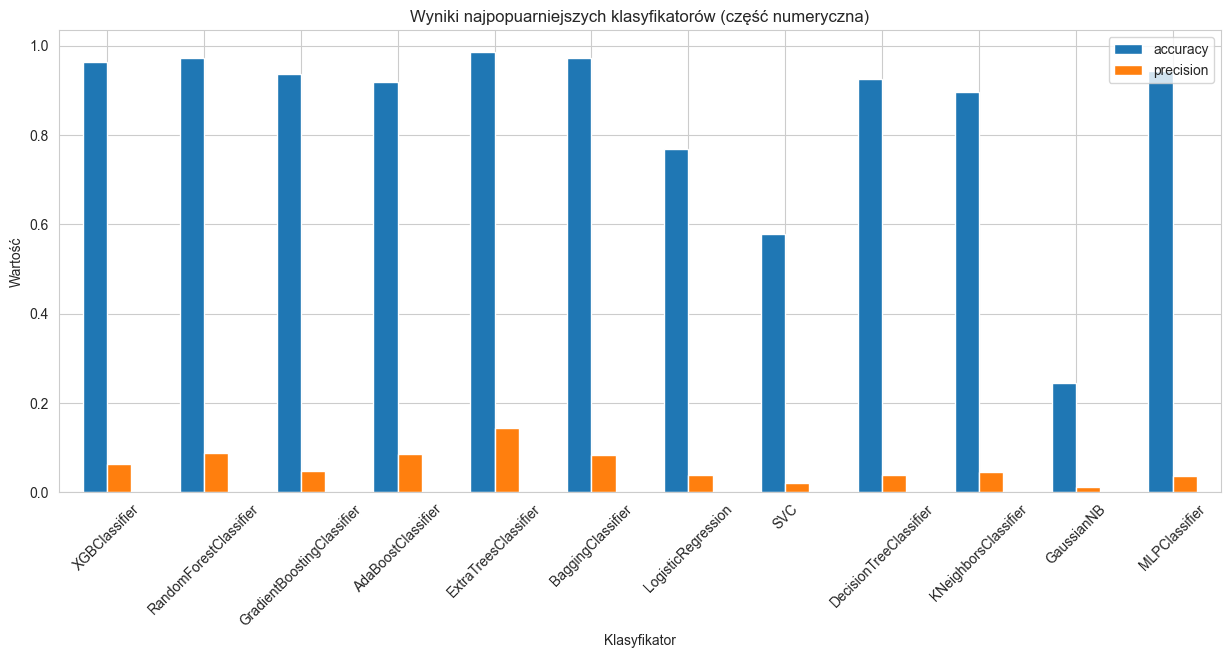

In [28]:
results_df.plot(
    x='classifier',
    y=['accuracy', 'precision'],
    kind='bar',
    figsize=(15, 6),
    title='Wyniki najpopuarniejszych klasyfikatorów (część numeryczna)',
    xlabel='Klasyfikator',
    ylabel='Wartość')

plt.xticks(rotation=45)

plt.show()

### Looking for best hyperparameters for XGBClassifier

In [147]:
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score

In [75]:
split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
ps = PredefinedSplit(test_fold=split_index)

In [23]:
from collections import Counter
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1] 

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=random_state)
extraTreesClassifier = ExtraTreesClassifier(random_state=random_state)
adaBoostClassifier = AdaBoostClassifier(random_state=random_state)
decisionTreeClassifier = DecisionTreeClassifier(random_state=random_state)
kNeighborsClassifier = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=7, leaf_size=10, algorithm='brute')

param_dist_XGBClassifier = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.06, 0.1, 1],
    'max_depth': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1]
    # 'scale_pos_weight': np.linspace(30, 60, 7)
}

param_dist_ExtraTreesClassifier = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [{True: 59, False: 1}, {True: 49, False: 1}, {True: 39, False: 1}, {True: 30, False: 1}, {True: 20, False: 1}, {True: 1, False: 1}, {True: 2, False: 1}]
}

param_dist_adaboostClassifier = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

param_dist_DecisionTreeClassifier = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 3, 5, 7, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [{True: 50, False: 1},{True: 30, False: 1}, {True: 10, False: 1}, {True: 2, False: 1}]
}

NameError: name 'XGBClassifier' is not defined

In [139]:
random_state = 42
for i in tqdm(range(5)):
    random_search = RandomizedSearchCV(
        estimator=adaBoostClassifier, 
        param_distributions=param_dist_adaboostClassifier,
        n_iter=20,
        scoring='precision',
        n_jobs=-1,
        random_state=random_state+i
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"Best parameters found: {random_search.best_params_}")
    
    best_xgb = random_search.best_estimator_
    
    y_pred = best_xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")

 20%|██        | 1/5 [00:38<02:33, 38.46s/it]

Best parameters found: {'n_estimators': 100, 'learning_rate': 1}
Test Accuracy: 0.9793510324483776
Test Precision: 0.2


 20%|██        | 1/5 [00:54<03:37, 54.36s/it]


KeyboardInterrupt: 

##### XGBClassifier results:

Best parameters found: {'subsample': 0.8, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.2}
Test Accuracy: 0.9505041246562786
Test Precision: 0.09433962264150944

Best parameters found: {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2}
Test Accuracy: 0.9908340971585701
Test Precision: 1.0

Best parameters found: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': {True: 30, False: 1}}
Test Accuracy: 0.9808259587020649
Test Precision: 0.4166666666666667

#### ExtraTreesClassifier results:

Best parameters found: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': {True: 10, False: 1}}
Test Accuracy: 0.29880843263061413
Test Precision: 0.012919896640826873


In [166]:
for i in tqdm(range(10)):
    adaBoostClassifier = DecisionTreeClassifier(random_state=55+i)
    
    adaBoostClassifier.fit(X_train, y_train)
    
    y_pred = adaBoostClassifier.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    if precision > 0.06:
        print(f"Test Precision: {precision}")
        print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [122]:
xgb_clf = XGBClassifier(objective='binary:logistic')

# Define a hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3, 1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

early_stopping_rounds = 10

grid_search = RandomizedSearchCV(
    estimator=xgb_clf, 
    param_distributions=param_grid,
    n_iter=40,
    scoring='accuracy',
    cv=3,
    n_jobs=1,
    verbose=1,
    random_state=42
)

grid_search.fit(X_train, y_train, 
                eval_set=[(X_val, y_val)],
                verbose=False)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred):.4f}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 1, 'colsample_bytree': 1.0}
Test Accuracy: 0.9808
Test Precision: 0.0000


In [121]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)

C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Running XGBoost on original dataset

In [132]:
financial_dataset = pd.read_csv('numerical_dataset_version5_original.csv')

flatten_df = flatten_financial_dataset(financial_dataset)

financial_dataset_flatten_preprocessed = flatten_df.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = financial_dataset_flatten_preprocessed.drop('label', axis=1)
y = financial_dataset_flatten_preprocessed['label']

In [133]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

len(X_train), len(X_val), len(X_test)

(3563, 225, 678)

In [125]:
# from sklearn import preprocessing
# 
# scaler = preprocessing.StandardScaler().fit(X_train)
# 
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

In [84]:
from sklearn.model_selection import PredefinedSplit

split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
ps = PredefinedSplit(test_fold=split_index)

In [43]:
random_state = 42
for i in tqdm(range(5)):
    random_search = RandomizedSearchCV(
        estimator=xgb, 
        param_distributions=param_dist_XGBClassifier,
        n_iter=100,
        scoring='precision',
        n_jobs=-1,
        cv=ps,
        random_state=random_state+i
    )
    
    random_search.fit(X_train_val, y_train_val)
    
    print(f"Best parameters found: {random_search.best_params_}")
    
    best_xgb = random_search.best_estimator_
    
    y_pred = best_xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")

  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'RandomizedSearchCV' is not defined

Best parameters found: {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06, 'gamma': 0.3}
Test Accuracy: 0.9908340971585701
Test Precision: 1.0

In [141]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracies = []
precisions = []
recalls = []

for i in tqdm(range(5)):
    
    model_numerical = AdaBoostClassifier(random_state=random_state+i,
                                        n_estimators=100,
                                        learning_rate=1)
    
    decisionTreeClassifier = DecisionTreeClassifier(random_state=random_state+i,
                                                    min_samples_split=2,
                                                    min_samples_leaf=1,
                                                    max_depth=10,
                                                    criterion='entropy',
                                                    class_weight={True: 30, False: 1})
    # model_numerical = XGBClassifier(
    #     random_state=random_state+i,
    #     subsample=0.7,
    #     n_estimators=100,
    #     max_depth=10,
    #     learning_rate=0.1,
    #     gamma=0.1,
    #     reg_alpha=0.01,
    #     scale_pos_weight=30
    # )
    
    decisionTreeClassifier.fit(X_train, y_train)
    
    y_pred = decisionTreeClassifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
print(f"Mean Accuracy: {np.mean(accuracies)}")
print(f"Mean Precision: {np.mean(precisions)}")
print(f"Mean Recall: {np.mean(recalls)}")

    # print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
    # print(f"Test Precision: {precision_score(y_test, y_pred)}")
    # print(f"Test Recall: {recall_score(y_test, y_pred)}")

100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

Mean Accuracy: 0.9778761061946903
Mean Precision: 0.3468864468864469
Mean Recall: 0.4


Test Accuracy: 0.9852507374631269
Test Precision: 1.0

### KNeighborsClassifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score

kNeighborsClassifier = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=7, leaf_size=10, algorithm='brute')

kNeighborsClassifier.fit(X_train, y_train)

y_pred = kNeighborsClassifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.8835930339138405
Test Precision: 0.03968253968253968


#### Choosing best models among LogisticRegression and SVC

#### LogisticRegression

In [19]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

model = LogisticRegression(random_state=random_state, penalty='l2')

param_distributions = {
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'C': np.logspace(-2, 3, 20),
    'max_iter': [50, 100, 200, 400, 600, 800],
    'solver': ['newton-cholesky', 'lbfgs', 'liblinear'],
    'class_weight': [{True: 50, False: 1},{True: 30, False: 1}, {True: 10, False: 1}, {True: 2, False: 1}]
}

In [21]:
for i in tqdm(range(10)):
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,  scoring='precision', n_iter=40, random_state=random_state+1, n_jobs=-1)
    
    grid_result = grid.fit(X_train, y_train)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    preds = grid_result.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, preds)}")
    print(f"Precision: {precision_score(y_test, preds)}")

 10%|█         | 1/10 [00:44<06:44, 44.98s/it]

Best: 0.132712 using {'tol': 0.001, 'solver': 'liblinear', 'max_iter': 600, 'class_weight': {True: 10, False: 1}, 'C': 162.3776739188721}
Accuracy: 0.9660766961651918
Precision: 0.2


 20%|██        | 2/10 [01:23<05:29, 41.23s/it]

Best: 0.132712 using {'tol': 0.001, 'solver': 'liblinear', 'max_iter': 600, 'class_weight': {True: 10, False: 1}, 'C': 162.3776739188721}
Accuracy: 0.9660766961651918
Precision: 0.2


 30%|███       | 3/10 [02:04<04:46, 40.98s/it]

Best: 0.132712 using {'tol': 0.001, 'solver': 'liblinear', 'max_iter': 600, 'class_weight': {True: 10, False: 1}, 'C': 162.3776739188721}
Accuracy: 0.9660766961651918
Precision: 0.2


 40%|████      | 4/10 [02:41<03:57, 39.63s/it]

Best: 0.132712 using {'tol': 0.001, 'solver': 'liblinear', 'max_iter': 600, 'class_weight': {True: 10, False: 1}, 'C': 162.3776739188721}
Accuracy: 0.9660766961651918
Precision: 0.2


 50%|█████     | 5/10 [03:22<03:20, 40.05s/it]

Best: 0.132712 using {'tol': 0.001, 'solver': 'liblinear', 'max_iter': 600, 'class_weight': {True: 10, False: 1}, 'C': 162.3776739188721}
Accuracy: 0.9660766961651918
Precision: 0.2


 50%|█████     | 5/10 [03:26<03:26, 41.38s/it]


KeyboardInterrupt: 

#### SVC

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np
from tqdm import tqdm

svc = SVC(random_state=random_state)

param_distributions = {
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'C': np.logspace(-2, 3, 10),
    'max_iter': [100, 200, 400, 600, 800],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5, 6],
    'class_weight': [{True: 50, False: 1},{True: 30, False: 1}, {True: 10, False: 1}, {True: 2, False: 1}]
}

In [24]:
for i in tqdm(range(5)):
    grid = RandomizedSearchCV(estimator=svc, param_distributions=param_distributions, scoring='precision', n_iter=40, random_state=random_state+i, n_jobs=-1)
    
    grid_result = grid.fit(X_train, y_train)

    print(f"iteration: {i+1}")
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    preds = grid_result.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, preds)}")
    print(f"Precision: {precision_score(y_test, preds)}")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=600).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 20%|██        | 1/5 [00:03<00:12,  3.20s/it]

iteration: 1
Best: 0.982880 using {'tol': 0.001, 'max_iter': 600, 'kernel': 'rbf', 'degree': 3, 'class_weight': {True: 10, False: 1}, 'C': 0.464158883361278}
Accuracy: 0.016224188790560472
Precision: 0.016224188790560472


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|████      | 2/5 [00:05<00:08,  2.94s/it]

iteration: 2
Best: 0.983160 using {'tol': 1e-05, 'max_iter': 400, 'kernel': 'rbf', 'degree': 4, 'class_weight': {True: 2, False: 1}, 'C': 77.42636826811278}
Accuracy: 0.9837758112094396
Precision: 0.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|██████    | 3/5 [00:08<00:05,  2.96s/it]

iteration: 3
Best: 0.983160 using {'tol': 0.01, 'max_iter': 200, 'kernel': 'sigmoid', 'degree': 3, 'class_weight': {True: 2, False: 1}, 'C': 0.03593813663804628}
Accuracy: 0.9837758112094396
Precision: 0.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

iteration: 4
Best: 0.983160 using {'tol': 0.0001, 'max_iter': 400, 'kernel': 'rbf', 'degree': 5, 'class_weight': {True: 2, False: 1}, 'C': 0.03593813663804628}
Accuracy: 0.9837758112094396
Precision: 0.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 5/5 [00:14<00:00,  2.80s/it]

iteration: 5
Best: 0.983160 using {'tol': 0.01, 'max_iter': 800, 'kernel': 'rbf', 'degree': 2, 'class_weight': {True: 10, False: 1}, 'C': 0.03593813663804628}
Accuracy: 0.9837758112094396
Precision: 0.0


### Checking TabPFN: A Transformer That Solves Small Tabular Classification Problems in a Second

In [167]:
financial_dataset = pd.read_csv('numerical_dataset_version5_original.csv')
financial_dataset = flatten_financial_dataset(financial_dataset)
financial_dataset_preprocessed = financial_dataset.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = financial_dataset_preprocessed.drop('label', axis=1)
y = financial_dataset_preprocessed['label']

In [168]:
financial_dataset_preprocessed.isnull().sum().sum(), (financial_dataset_preprocessed == 0).sum().sum()

(0, 5514)

In [169]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

len(X_train), len(X_val), len(X_test)

(3563, 225, 678)

In [170]:
concat_train_and_val = False

if concat_train_and_val:
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    scaler = preprocessing.StandardScaler().fit(X_train_val)
    
    X_train_val = scaler.transform(X_train_val)
    X_test = scaler.transform(X_test)
    
else:
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

In [173]:
from tabpfn import TabPFNClassifier

tabPFNClassifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=16)

tabPFNClassifier.fit(X_train, y_train)

y_eval, p_eval = tabPFNClassifier.predict(X_test, return_winning_probability=True)

accuracy = accuracy_score(y_test, y_eval)
precision = precision_score(y_test, y_eval)

print(f"Accuracy:", accuracy)
print(f"Precision:", precision)


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Accuracy: 0.9837758112094396
Precision: 0.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Running best model on the whole new dataset (https://github.com/sowide/bankruptcy_dataset)

In [8]:
american_bankruptcy_dataset = pd.read_csv('american_bankruptcy_dataset.csv')
print(american_bankruptcy_dataset.shape)

(78682, 23)


In [9]:
american_bankruptcy_dataset_grouped = american_bankruptcy_dataset.groupby('company_name')
american_bankruptcy_dataset_filtered = american_bankruptcy_dataset_grouped.filter(lambda x: len(x) >= 5)
print(american_bankruptcy_dataset_filtered.shape)

(71123, 23)


In [10]:
american_bankruptcy_dataset_grouped = american_bankruptcy_dataset_filtered.groupby('company_name')
american_bankruptcy_dataset_5years = pd.DataFrame()

for group in american_bankruptcy_dataset_grouped:
    if len(group[1]) >= 5:
        last_5_years = group[1].tail(5)
        american_bankruptcy_dataset_5years = pd.concat([american_bankruptcy_dataset_5years, last_5_years])
        
print(american_bankruptcy_dataset_5years.shape)

(29365, 23)


In [11]:
american_bankruptcy_dataset_5years.head()

,company_name,fyear,status_label,X1,X2,X3,X4,X5,X6,X7,...,X11,X12,X13,X14,X15,X16,X17,X18,Division,MajorGroup
14,C_1,2013.0,alive,1116.9,2199.5,1581.4,564.3,113.4,142.6,256.0,...,72.9,616.7,297.9,2035.0,9.613080e+05,1198.8,2035.0,1779.0,D,37
15,C_1,2014.0,alive,954.1,1515.0,1342.7,85.0,92.3,-8.6,83.7,...,10.2,603.9,231.1,1594.3,1.046395e+03,669.9,1594.3,1510.6,D,37
16,C_1,2015.0,alive,873.1,1442.1,1354.9,136.1,70.8,66.1,136.9,...,47.7,637.2,242.7,1662.6,8.425112e+02,576.3,1662.6,1525.7,D,37
17,C_1,2016.0,alive,888.5,1504.1,1422.7,155.3,71.0,77.2,148.2,...,56.5,688.0,251.4,1767.6,1.200329e+03,589.9,1767.6,1619.4,D,37
18,C_1,2017.0,alive,942.7,1524.7,1413.2,177.2,40.5,86.0,126.5,...,15.6,701.2,203.0,1748.3,1.551458e+06,588.4,1748.3,1621.8,D,37


In [12]:
# dropping X9 (Net sales) column because there are no equivalent columns in the created financial dataset
american_bankruptcy_dataset_5years.drop(['X9'], axis=1, inplace=True)

american_bankruptcy_dataset_5years.columns = [
    'company_name',
    'fyear',
    'label',
    'Current assets',
    'Cost of goods sold',
    'Depreciation and amortization',
    'EBITDA', 
    'Inventory',
    'Net Income',
    'Total Receivables',
    'Market value',
    'Total assets',
    'Total Long term debt',
    'EBIT',
    'Gross Profit',
    'Total Current Liabilities',
    'Retained Earnings',
    'Total Revenue',
    'Total Liabilities',
    'Total Operating Expenses',
    'Division',
    'MajorGroup'
]

# reordering columns so Division and MajorGroup are after label
american_bankruptcy_dataset_5years = american_bankruptcy_dataset_5years[['company_name', 'fyear', 'label', 'Division', 'MajorGroup', 
                                                                         'Cost of goods sold', 'Depreciation and amortization', 'EBIT',  
                                                                         'EBITDA', 'Gross Profit', 'Total Long term debt', 'Market value', 'Net Income', 
                                                                         'Retained Earnings', 'Total Revenue', 'Total assets', 'Current assets',
                                                                         'Total Current Liabilities', 'Inventory', 'Total Liabilities', 
                                                                         'Total Operating Expenses', 'Total Receivables', 
                                                                         
                                                                         
                                                                         ]]

# renaming columns names with features to much with the financial dataset
american_bankruptcy_dataset_5years.columns = [
    'company_name',
    'fyear',
    'label',
    'Division',
    'MajorGroup',
    'Cost of Goods Sold',
    'Depreciation, Depletion and Amortization',
    'EBIT',
    'EBITDA',
    'Gross Profit',
    'Long-Term Debt',
    'Market Cap',
    'Net Income',
    'Retained Earnings',
    'Revenue',
    'Total Assets',
    'Total Current Assets',
    'Total Current Liabilities',
    'Total Inventories',
    'Total Liabilities',
    'Total Operating Expense',
    'Total Receivables'
]

american_bankruptcy_dataset_5years['label'] = american_bankruptcy_dataset_5years['label'].apply(lambda x: True if x == 'failed' else False)
american_bankruptcy_dataset_5years.to_csv('sowide_american_bankruptcy_dataset_5years_named_features_withoutX9.csv', index=False)

american_bankruptcy_dataset_5years.head(10)

,company_name,fyear,label,Division,MajorGroup,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
14,C_1,2013.0,False,D,37,2199.5,1581.4,616.7,564.3,297.900,...,142.600,9.613080e+05,1198.80,402.100,1116.900,2035.0,113.4,2035.0,1779.0,256.000
15,C_1,2014.0,False,D,37,1515.0,1342.7,603.9,85.0,231.100,...,-8.600,1.046395e+03,669.90,412.000,954.100,1594.3,92.3,1594.3,1510.6,83.700
16,C_1,2015.0,False,D,37,1442.1,1354.9,637.2,136.1,242.700,...,66.100,8.425112e+02,576.30,329.000,873.100,1662.6,70.8,1662.6,1525.7,136.900
17,C_1,2016.0,False,D,37,1504.1,1422.7,688.0,155.3,251.400,...,77.200,1.200329e+03,589.90,335.100,888.500,1767.6,71.0,1767.6,1619.4,148.200
18,C_1,2017.0,False,D,37,1524.7,1413.2,701.2,177.2,203.000,...,86.000,1.551458e+06,588.40,333.300,942.700,1748.3,40.5,1748.3,1621.8,126.500
125,C_10,2014.0,False,E,49,14313532.0,2263032.0,1857924.0,3031215.0,395179.000,...,811242.000,7.553105e+06,9794.43,1559.143,973435.000,3491632.0,417358.0,3491632.0,2263032.0,1228.600
126,C_10,2015.0,False,E,49,15028258.0,2146419.0,2048055.0,3462391.0,367806.000,...,854602.000,7.155990e+03,10308801.00,1442317.000,890.516,3495443.0,494422.0,3495443.0,2146419.0,1349024.000
127,C_10,2016.0,False,E,49,16004253.0,2156869.0,2211725.0,4021785.0,355403.000,...,855.984,8.687626e+03,11068341.00,1292946.000,822.219,3498682.0,485829.0,3498682.0,2156869.0,1341813.000
128,C_10,2017.0,False,E,49,17019082.0,2096751.0,2397509.0,4789713.0,415068.000,...,934427.000,9.519035e+03,11883352.00,1197852.000,1016288.000,3565296.0,534118.0,3565296.0,2096751.0,1468545.000
129,C_10,2018.0,False,E,49,17664202.0,2335206.0,2593475.0,4638232.0,400.988,...,773687.000,9.551090e+03,12315497.00,1648964.000,924991.000,3691247.0,582354.0,3691247.0,2335206.0,1356.041


In [259]:
american_bankruptcy_dataset_5years['label'].value_counts(normalize=True)

label
False    0.914013
True     0.085987
Name: proportion, dtype: float64

In [13]:
american_bankruptcy_dataset_5years = pd.read_csv('sowide_american_bankruptcy_dataset_5years_named_features_withoutX9.csv')
american_bankruptcy_dataset_5years.head()

,company_name,fyear,label,Division,MajorGroup,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,C_1,2013.0,False,D,37,2199.5,1581.4,616.7,564.3,297.9,...,142.6,9.613080e+05,1198.8,402.1,1116.9,2035.0,113.4,2035.0,1779.0,256.0
1,C_1,2014.0,False,D,37,1515.0,1342.7,603.9,85.0,231.1,...,-8.6,1.046395e+03,669.9,412.0,954.1,1594.3,92.3,1594.3,1510.6,83.7
2,C_1,2015.0,False,D,37,1442.1,1354.9,637.2,136.1,242.7,...,66.1,8.425112e+02,576.3,329.0,873.1,1662.6,70.8,1662.6,1525.7,136.9
3,C_1,2016.0,False,D,37,1504.1,1422.7,688.0,155.3,251.4,...,77.2,1.200329e+03,589.9,335.1,888.5,1767.6,71.0,1767.6,1619.4,148.2
4,C_1,2017.0,False,D,37,1524.7,1413.2,701.2,177.2,203.0,...,86.0,1.551458e+06,588.4,333.3,942.7,1748.3,40.5,1748.3,1621.8,126.5


In [14]:
def flatten_american_bankruptcy_dataset(financial_dataset):
    object_length_in_rows = 5
    metadata_columns_length = 5
    
    per_object_columns = list(financial_dataset.columns[:metadata_columns_length].values)
    
    value_columns = financial_dataset.columns[metadata_columns_length:]
    new_columns = per_object_columns + [f'{col}_{i+1}' for i in range(object_length_in_rows) for col in value_columns]
    
    dfs = []
    
    for i in range(0, len(financial_dataset), object_length_in_rows):
        group = financial_dataset.iloc[i:i + object_length_in_rows]
        if len(group) < object_length_in_rows:
            break

        company_name = group['company_name'].iloc[0]
        fiscal_periods = ';'.join(group['fyear'].astype(str).values)
        label = group['label'].iloc[0]
        division = group['Division'].iloc[0]
        major_group = group['MajorGroup'].iloc[0]

        values = group.drop(columns=per_object_columns).values.flatten()
        
        dfs.append([company_name, fiscal_periods, label, division, major_group] + values.tolist())
    
    final_flatten_df = pd.DataFrame(dfs, columns=new_columns)
    final_flatten_df = final_flatten_df.reset_index(drop=True)
    return final_flatten_df

In [15]:
# check how many zeros and Nan are in the dataset
american_bankruptcy_dataset_5years.isnull().sum().sum(), (american_bankruptcy_dataset_5years == 0).sum().sum()

(0, 36054)

In [16]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

american_bankruptcy_dataset_5years_zeros_filled = pd.DataFrame()
# 31385
for group in tqdm(american_bankruptcy_dataset_5years.groupby('company_name')):
    tmp_df = group[1].replace(to_replace=0, method='bfill').replace(to_replace=0, method='ffill')
    american_bankruptcy_dataset_5years_zeros_filled = pd.concat([american_bankruptcy_dataset_5years_zeros_filled, tmp_df])

100%|██████████| 5873/5873 [00:21<00:00, 272.75it/s]


In [17]:
american_bankruptcy_dataset_5years_zeros_filled.isnull().sum().sum(), (american_bankruptcy_dataset_5years_zeros_filled == 0).sum().sum()

(0, 31385)

In [18]:
american_bankruptcy_dataset_5years_zeros_filled['label'].value_counts()

label
False    26840
True      2525
Name: count, dtype: int64

In [19]:
american_bankruptcy_dataset_5years_zeros_filled['label'].value_counts(normalize=True)

label
False    0.914013
True     0.085987
Name: proportion, dtype: float64

In [20]:
len(american_bankruptcy_dataset_5years_zeros_filled)/5

5873.0

In [21]:
american_bankruptcy_dataset_5years_flatten = flatten_american_bankruptcy_dataset(american_bankruptcy_dataset_5years_zeros_filled)
american_bankruptcy_dataset_5years_preprocessed = american_bankruptcy_dataset_5years_flatten.drop(['company_name', 'fyear', 'Division', 'MajorGroup'], axis=1)

In [22]:
X_american_bankruptcy_dataset = american_bankruptcy_dataset_5years_preprocessed.drop('label', axis=1)
y_american_bankruptcy_dataset  = american_bankruptcy_dataset_5years_preprocessed['label']

scaler = preprocessing.StandardScaler().fit(X_american_bankruptcy_dataset)
X_scaled = scaler.transform(X_american_bankruptcy_dataset)

len(X_american_bankruptcy_dataset), len(y_american_bankruptcy_dataset)

(5873, 5873)

In [154]:
preds = decisionTreeClassifier.predict(X_american_bankruptcy_dataset)
print(f"Accuracy: {accuracy_score(y_american_bankruptcy_dataset, preds)}")
print(f"Precision: {precision_score(y_american_bankruptcy_dataset, preds)}")

Accuracy: 0.839775242635791
Precision: 0.07587548638132295


### Check only on the balanced dataset

In [166]:
X_negative = X_american_bankruptcy_dataset[y_american_bankruptcy_dataset == False]
y_negative = y_american_bankruptcy_dataset[y_american_bankruptcy_dataset == False]

X_positive = X_american_bankruptcy_dataset[y_american_bankruptcy_dataset == True]
y_positive = y_american_bankruptcy_dataset[y_american_bankruptcy_dataset == True]

X_negative = X_negative.sample(n=len(X_positive), random_state=random_state+7)
y_negative = y_negative.sample(n=len(X_positive), random_state=random_state+7)

X_combined = pd.concat([X_positive, X_negative])
y_combined = pd.concat([y_positive, y_negative])

len(X_positive), len(y_positive), len(X_negative), len(y_negative)

(505, 505, 505, 505)

In [163]:
X_negative = X_negative.sample(n=len(X_positive)//60, random_state=random_state+i)
y_negative = y_negative.sample(n=len(X_positive)//60, random_state=random_state+i)

X_combined = pd.concat([X_positive, X_negative])
y_combined = pd.concat([y_positive, y_negative])
preds = decisionTreeClassifier.predict(X_combined)

accuracy = accuracy_score(y_combined, preds)
precision = precision_score(y_combined, preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

Accuracy: 0.08966861598440545
Precision: 0.975


In [167]:
accuracies = []
precisions = []

for i in tqdm(range(100)):
    X_negative = X_negative.sample(n=len(X_positive), random_state=random_state+i)
    y_negative = y_negative.sample(n=len(X_positive), random_state=random_state+i)
    
    X_combined = pd.concat([X_positive, X_negative])
    y_combined = pd.concat([y_positive, y_negative])
    preds = decisionTreeClassifier.predict(X_combined)
    
    accuracy = accuracy_score(y_combined, preds)
    precision = precision_score(y_combined, preds)
    
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    
    accuracies.append(accuracy)
    precisions.append(precision)
    
print(f"Mean accuracy: {np.mean(accuracies)}")
print(f"Mean precision: {np.mean(precisions)}")


100%|██████████| 100/100 [00:00<00:00, 351.57it/s]

Mean accuracy: 0.4821782178217822
Mean precision: 0.40625


#### Results for american dataset:

Accuracy: 0.42475247524752474
Precision: 0.4291044776119403

## Dataset comparison

In [86]:
df1 = pd.read_csv('numerical_dataset_version5_original.csv')
df2 = pd.read_csv('sowide_american_bankruptcy_dataset_5years_named_features_withoutX9.csv')

df1.drop(['cik', 'ticker', 'Fiscal Period', 'label', 'subset'], axis=1, inplace=True)
df2.drop(['company_name', 'fyear', 'Division', 'MajorGroup', 'label'], axis=1, inplace=True)

In [87]:
df1.describe()

,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
count,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000,22330.000000
mean,2804.200786,222.866117,398.594389,647.420785,1349.241089,2355.462146,7757.127167,259.033829,1321.414790,3585.979678,8904.679528,1805.225018,1277.980019,433.914126,6651.132837,947.781048,674.301173
std,12369.437296,992.374917,2476.740748,3104.565968,5036.434723,11671.391981,29582.063574,1961.031488,11497.421934,15472.447328,37632.370805,6835.098524,5095.109401,1648.969248,31288.700681,3444.501464,3383.087339
min,-1647.000000,-59.000000,-27725.000000,-27317.000000,-5685.000000,0.000000,0.000000,-27590.000000,-85041.000000,-1992.140000,0.000000,0.000000,0.000000,0.000000,-4733.000000,-3518.000000,0.000000
25%,151.000000,8.000000,3.000000,25.425000,128.800000,126.025000,458.000000,-3.000000,-103.500000,179.800000,555.000000,173.000000,79.700000,23.000000,303.000000,107.600000,26.000000
50%,484.000000,34.000000,64.000000,118.000000,324.000000,452.800000,1495.500000,24.410000,55.000000,602.800000,1476.795000,398.000000,211.000000,90.000000,930.000000,244.000000,92.000000
75%,1625.750000,125.000000,284.000000,437.000000,904.000000,1605.000000,4709.750000,135.000000,463.875000,2045.750000,4689.000000,1142.750000,677.000000,332.000000,3144.000000,631.000000,333.000000
max,420315.000000,46009.000000,111852.000000,123136.000000,152836.000000,429944.000000,995107.000000,94680.000000,444626.000000,559151.000000,992968.000000,184406.000000,125481.000000,81715.000000,902703.000000,116288.000000,128387.000000


In [88]:
df2.describe()

,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
count,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04
mean,6.243817e+05,3.833786e+05,2.361547e+04,1.764228e+05,6.900689e+04,1.254670e+04,1.745298e+05,4.144138e+04,4.968603e+05,3.856770e+05,1.289232e+05,2.150358e+05,5.592116e+05,2.594476e+04,5.592116e+05,4.750706e+05,6.586093e+04
std,2.057566e+06,2.415372e+06,8.377113e+05,8.014096e+05,2.845943e+05,1.895519e+05,5.936148e+05,2.225606e+05,5.364679e+06,1.454710e+06,5.471249e+05,7.071624e+05,2.742011e+06,1.005920e+05,2.742011e+06,2.256353e+06,2.662746e+05
min,7.000000e-03,-3.143700e+04,-1.900383e+07,-2.300000e+01,0.000000e+00,-7.058978e+06,-4.367571e+06,-5.043795e+06,1.000000e-04,7.000000e-03,7.000000e-03,-2.498000e+03,-1.977000e+03,0.000000e+00,-1.977000e+03,-3.143700e+04,-4.512135e+06
25%,3.480900e+03,1.355600e+03,-5.355800e+04,0.000000e+00,2.125000e+02,-3.991000e+03,4.117600e+02,-1.392000e+03,4.155930e+01,2.224707e+03,1.062400e+03,1.292000e+03,1.941200e+03,7.300000e+01,1.941200e+03,3.113000e+03,-3.267000e+01
50%,4.448300e+04,2.078200e+04,-8.027000e+01,5.752870e+02,4.119000e+03,5.547000e+00,1.165600e+04,1.624000e+02,3.446880e+02,1.963200e+04,1.169300e+04,2.196500e+04,3.424400e+04,1.162400e+03,3.424400e+04,3.929200e+04,8.870000e+02
75%,3.458750e+05,1.730550e+05,1.414400e+04,1.986100e+04,3.916900e+04,5.894000e+03,1.132980e+05,1.541500e+04,3.157765e+03,1.662730e+05,7.300300e+04,1.549930e+05,3.132310e+05,1.280800e+04,3.132310e+05,2.746480e+05,2.973200e+04
max,4.827507e+07,1.632456e+08,3.095666e+07,2.068708e+07,1.154206e+07,7.521731e+06,1.724914e+07,6.946234e+06,3.748024e+08,3.921136e+07,2.786969e+07,2.430330e+07,1.679396e+08,4.165616e+06,1.679396e+08,1.657008e+08,8.845605e+06


In [95]:
import seaborn as sns
import math
from matplotlib.patches import Rectangle

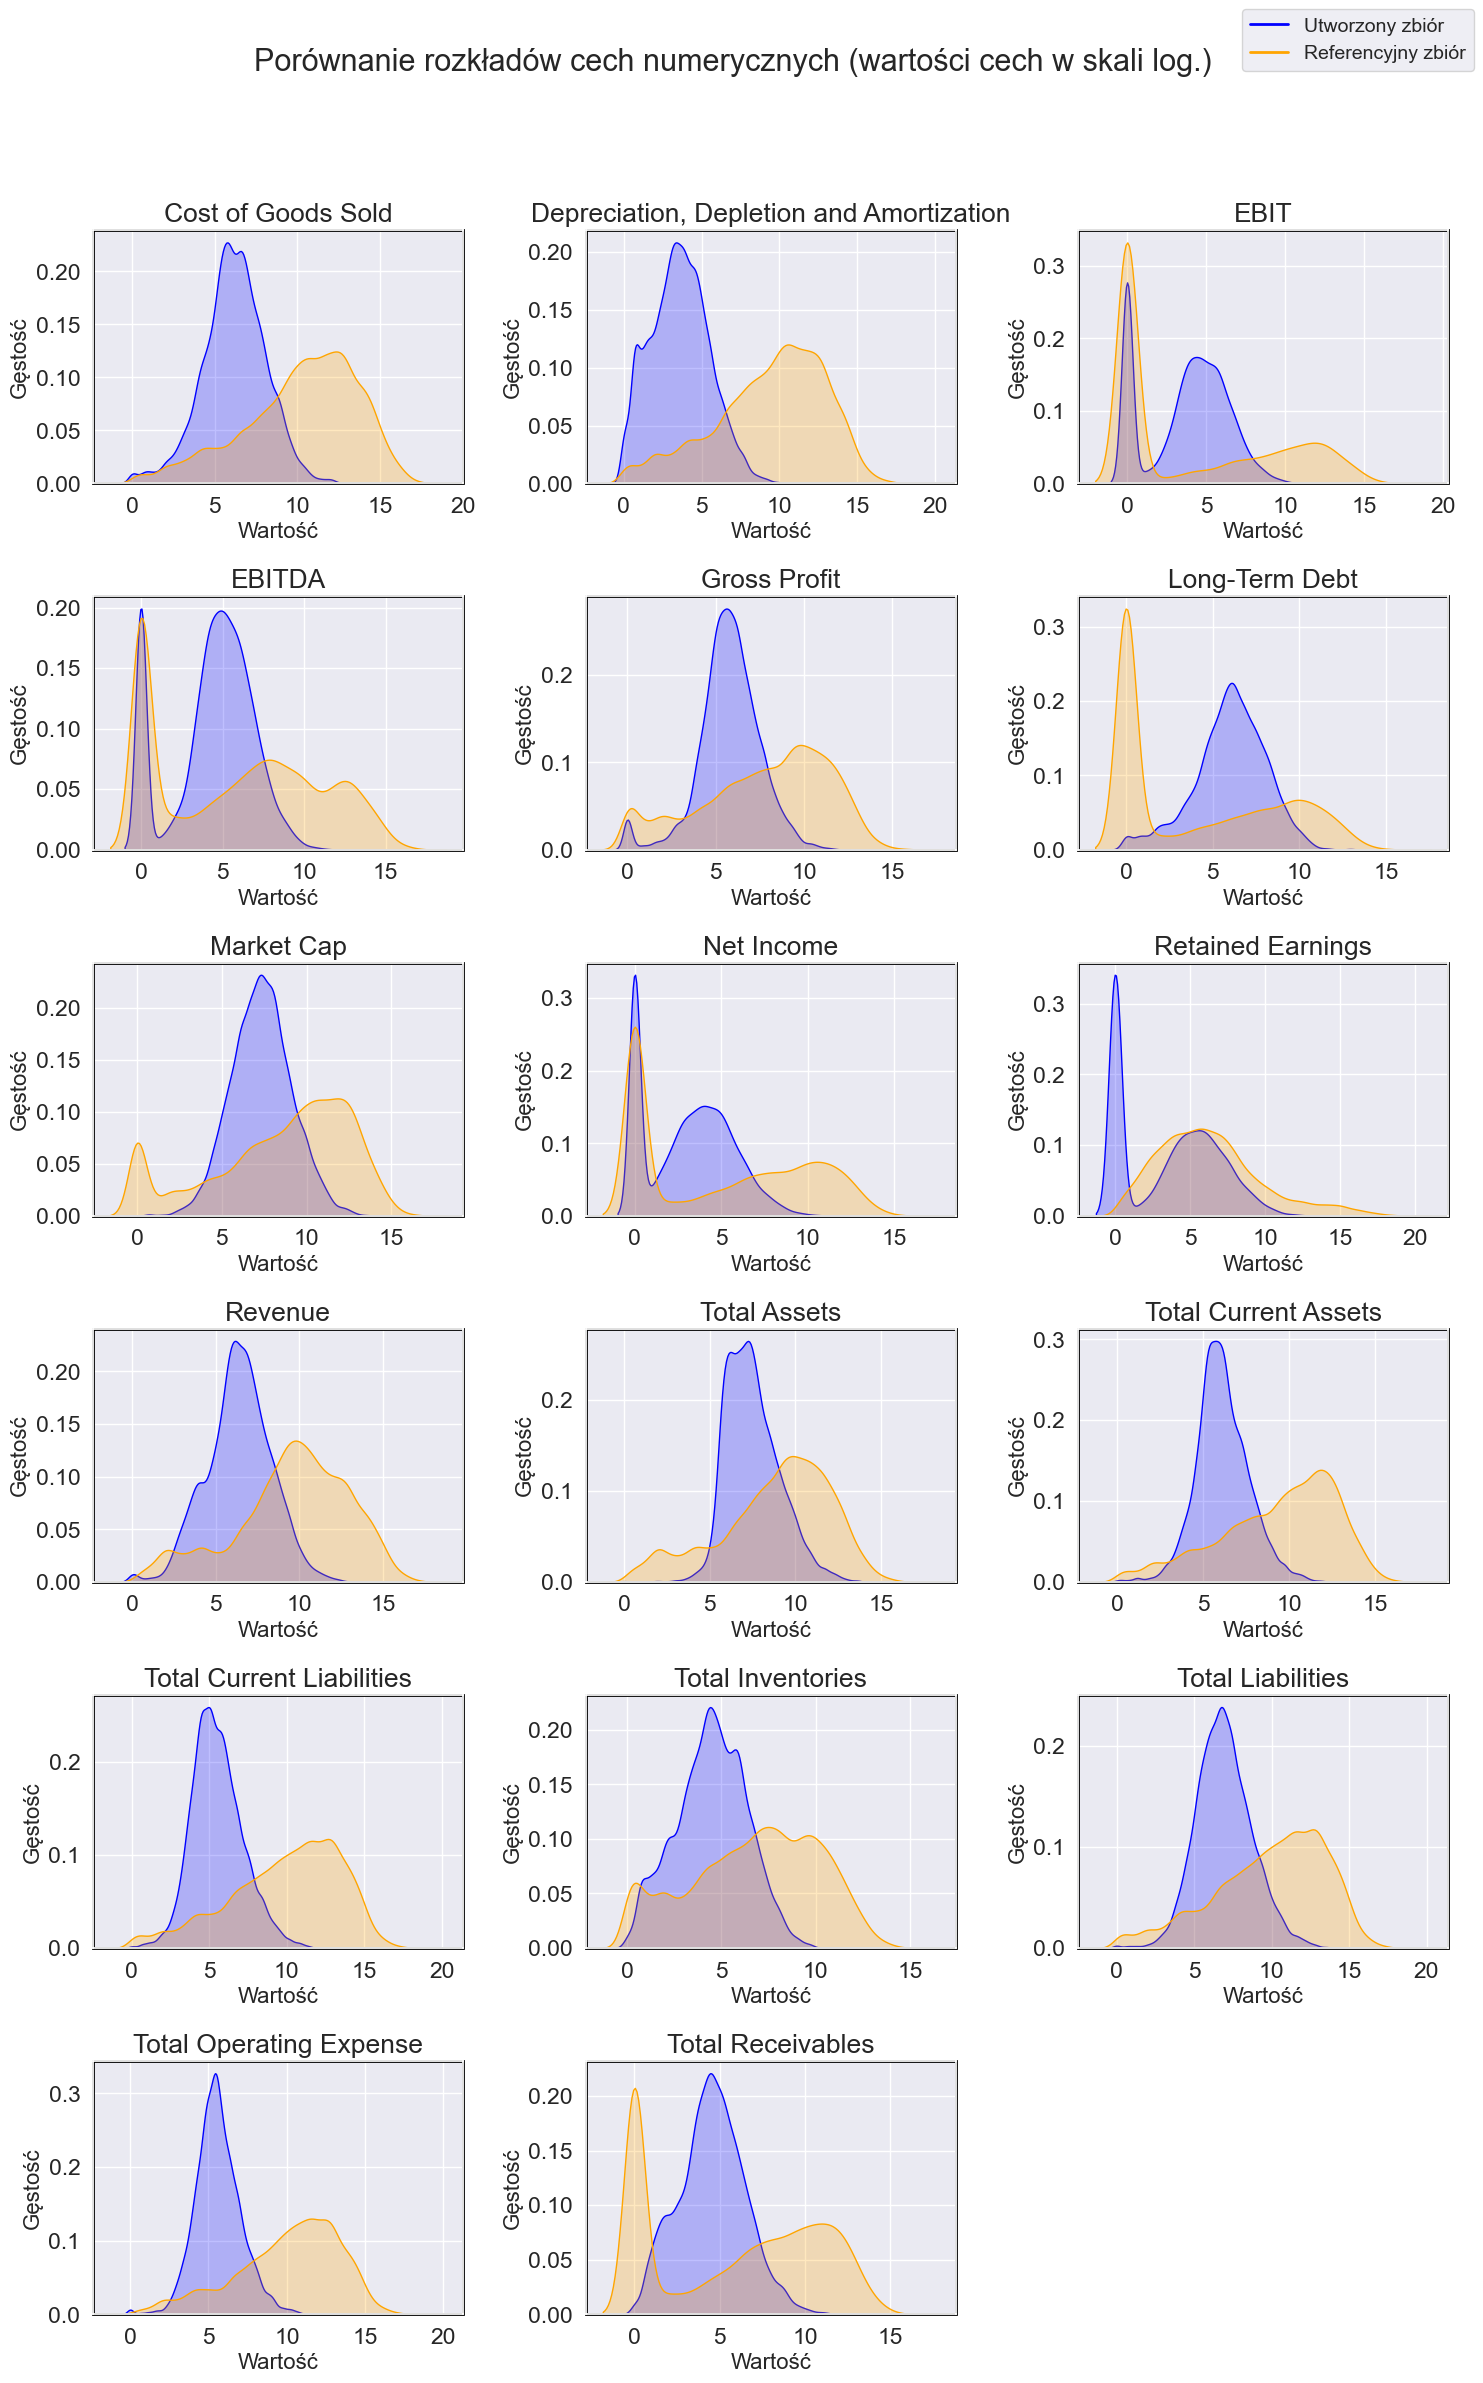

In [127]:
numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns

n_cols = 3
n_rows = math.ceil(len(numeric_columns) / n_cols)

# sns.set(font_scale=1.5)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Porównanie rozkładów cech numerycznych (wartości cech w skali log.)', fontsize=22)

axes = axes.flatten()

for idx, column in enumerate(numeric_columns):
    # Log transform both datasets, avoiding log(0) by adding a small constant
    df1_log = np.log1p(df1[column].clip(lower=1e-5))  # log1p(x) = log(1 + x), handles small values
    df2_log = np.log1p(df2[column].clip(lower=1e-5))
    
    sns.kdeplot(df1_log, shade=True, ax=axes[idx], color='blue')
    sns.kdeplot(df2_log, shade=True, ax=axes[idx], color='orange')
    axes[idx].set_title(f'{column}', fontsize=19)
    axes[idx].set_xlabel('Wartość', fontsize=16)
    axes[idx].set_ylabel('Gęstość', fontsize=16)
    
    axes[idx].add_patch(Rectangle(
        (0, 0), 1, 1, transform=axes[idx].transAxes, 
        fill=False, color='black', lw=2, clip_on=False))
    
    # if idx < 2:
    #     ax_pos = axes[idx].get_position()
    #     rect = plt.Rectangle(xy=(ax_pos.x0-0.04, ax_pos.y0),
    #                          width=0.33, height=0.16,
    #                          transform=fig.transFigure, figure=fig,
    #                          fill=False, color="k", lw=2, zorder=1000)
    #     fig.patches.extend([rect])

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])
# for i in range(n_rows):
#     for j in range(n_cols):
#         
# 
#         rect = plt.Rectangle(
#             # (lower-left corner), width, height
#             (0.333*j, i*0.155), 0.32, 0.16, fill=False, color="k", lw=2, 
#             zorder=1000, transform=fig.transFigure, figure=fig
#         )
#         fig.patches.extend([rect])

handles = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Utworzony zbiór'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Referencyjny zbiór')
]

fig.legend(handles=handles, loc='upper right', ncol=1, fontsize=14)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()